In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
#adjustable variables
yearly_data_path = 'path/to/joined/yearly/data'
modelling_year = 2001

In [3]:
year_df = pd.read_csv(f'{yearly_data_path}{modelling_year}.csv')

In [4]:
def bin_time(crs_time):
    bin_dict = {0: '00-06', 1: '06-12', 2: '12-18', 3: '18-00'}
    if crs_time == 2400:
        return '18-00'
    return bin_dict[crs_time // 600]

def get_season(month):
    season_dict = {(1,2,3): 'spring', (4,5,6): 'summer', (7,8,9): 'autumn', (10,11,12): 'winter'}
    for key, val in season_dict.items():
        if month in key:
            return val

In [5]:
#preprocessing
dep_use_cols = ['MONTH', 'DAY_OF_WEEK', 'CRS_DEP_TIME', 'DISTANCE', 'PRCP_ORIGIN', 'SNOW_ORIGIN', 'SNWD_ORIGIN', 'TMAX_ORIGIN', 'TMIN_ORIGIN', 'DEP_DELAY']
dep_df = year_df[dep_use_cols]
dep_df['CRS_DEP_BIN'] = dep_df['CRS_DEP_TIME'].apply(bin_time)        
dep_df['SEASON'] = dep_df['MONTH'].apply(get_season)
dep_df = dep_df.astype({'DAY_OF_WEEK': 'category'})

C:\Users\65845\AppData\Local\Temp\ipykernel_15988\1950920707.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dep_df['CRS_DEP_BIN'] = dep_df['CRS_DEP_TIME'].apply(bin_time)
C:\Users\65845\AppData\Local\Temp\ipykernel_15988\1950920707.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dep_df['SEASON'] = dep_df['MONTH'].apply(get_season)


In [6]:
#train-test split
dep_regression_cols = ['SEASON', 'DAY_OF_WEEK', 'CRS_DEP_BIN', 'DISTANCE', 'PRCP_ORIGIN', 'SNOW_ORIGIN', 'SNWD_ORIGIN', 'TMAX_ORIGIN', 'TMIN_ORIGIN', 'DEP_DELAY']
dep_regression_df = dep_df[dep_regression_cols]
dep_regression_df = dep_regression_df.dropna()
dep_X = pd.get_dummies(dep_regression_df.drop('DEP_DELAY', axis=1))
dep_y = dep_regression_df['DEP_DELAY']
dep_X_train, dep_X_test, dep_y_train, dep_y_test = train_test_split(dep_X, dep_y, test_size = 0.2)

In [7]:
# Ridge DEP

alphas = 10**np.linspace(10,-2,100)*0.5

ridge_dep_cv = RidgeCV(alphas=alphas)
ridge_dep_cv.fit(dep_X_train, dep_y_train)
print('best alpha: ' + ridge_dep_cv.alpha_.astype(str))

ridge_dep = Ridge(alpha = ridge_dep_cv.alpha_)
ridge_dep.fit(dep_X_train, dep_y_train)
print('MSE: ' + mean_squared_error(dep_y_test, ridge_dep.predict(dep_X_test)).astype(str))

best alpha: 87.37642000038414
MSE: 762.6324393210806


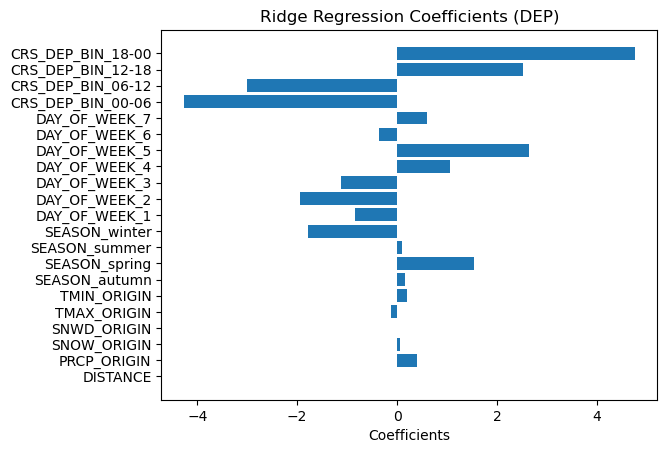

In [8]:
# Ridge DEP plot 

fig, ax = plt.subplots()
ax.barh(ridge_dep.feature_names_in_, ridge_dep.coef_)
ax.set_xlabel('Coefficients')
ax.set_title('Ridge Regression Coefficients (DEP)')
plt.show()